## A test for applying BERT to cloze task

According to the answer from github [How can I apply Bert to a cloze task](https://github.com/huggingface/transformers/issues/80#issuecomment-444445782)

In [42]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text = 'From Monday to Friday most people are busy working or studying, '\
       'but in the evenings and weekends they are free and _ themselves.'
tokenized_text = tokenizer.tokenize(text)

masked_index = tokenized_text.index('_')
tokenized_text[masked_index] = '[PAD]'

candidates = ['love', 'work', 'enjoy', 'play']
candidates_ids = tokenizer.convert_tokens_to_ids(candidates)

indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

segments_ids = [0] * len(tokenized_text)

tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

language_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
language_model.eval()

predictions = language_model(tokens_tensor, segments_tensors)
predictions_candidates = predictions[0, masked_index, candidates_ids]
answer_idx = torch.argmax(predictions_candidates).item()

print(f'The most likely word is "{candidates[answer_idx]}".')

The most likely word is "enjoy".


## Experiment of applying AUM to Bert based method

In [1]:
import torch
from pytorch_pretrained_bert import BertForSequenceClassification
from pytorch_pretrained_bert import BertConfig, BertAdam
# import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

In [2]:
import os
import numpy as np
import json

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import pickle
import time

from pytorch_pretrained_bert import BertTokenizer


class MultiNLIDataset(Dataset):
    def __init__(self,root='/media/felicia/Data/multinli',matched=True,tokenized=True,max_length=12):
        super(MultiNLIDataset,self).__init__()
        self.root=root
        self.matched=matched
        self.tokenized=tokenized
        self.max_length=max_length
        self.jsonfile="multinli_1.0_dev_matched.jsonl" if self.matched else "multinli_1.0_dev_mismatched.jsonl"
        self.filename=os.path.join(self.root,self.jsonfile)


        self.num_labels = 2
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.LABEL_MAP = {
                "entailment": 0,
                "neutral": 1,
                "contradiction": 2,
                "hidden": 0
            }

        self.data=[]
        self.sentences=[]
        self.labels=[]
        self.load_data()
        self.random_flip = torch.randint(9815, (200, ))
#         self.random_flip = torch.randint(800, (20, ))
        self.random_shift = dict()
        for flip_index in self.random_flip:
            self.random_shift[str(int(flip_index))] = int(2*(torch.rand(1)>0.5)-1)

    def load_data(self):
        with open(self.filename) as f:
            for idx, line in enumerate(f):
#                 if idx > 800:
#                     continue
                example=json.loads(line) # dict
                self.data.append(example)
        if self.tokenized:
            self.tokenize()

    
    def tokenize(self):
        for i, text in enumerate(self.data):
            sent=text["sentence1"]
            label=text["gold_label"]
            if label not in self.LABEL_MAP:
                continue

            tokenized_text = self.tokenizer.tokenize(sent)
            indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
            if len(indexed_tokens)<self.max_length:
                indexed_tokens+=[0]*(self.max_length-len(indexed_tokens))
            else:
                indexed_tokens=indexed_tokens[:self.max_length]
            indexed_tokens=np.array(indexed_tokens)

            self.sentences.append(indexed_tokens)
            self.labels.append(self.LABEL_MAP[label])
    
    def __getitem__(self,index):
        sent = self.sentences[index]
        if index in self.random_flip:
            label = self.labels[index]+self.random_shift[str(index)]
            if label>2:
                label = 0
            elif label<0:
                label = 2
        else:
            label = self.labels[index]

        return index,sent,label

    def __len__(self):
        return len(self.sentences)
#         return 800

In [3]:
# def Trainer(batch_size=4, epoch = 50, n_classes = 3, vocab_size = 30522):
batch_size=24
epoch = 50
n_classes = 3
vocab_size = 30522
writer = SummaryWriter('runs/NLP_AUM_First')

config = BertConfig(vocab_size)
model = BertForSequenceClassification(config, n_classes)
model.to("cuda")
dataset = MultiNLIDataset("./multinli_1.0", max_length=217)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
criterion = torch.nn.CrossEntropyLoss()
optimizer = BertAdam(model.parameters(), lr = 0.001)
aum = torch.zeros([epoch, len(dataset), n_classes]).cuda()

t_total value of -1 results in schedule not being applied


In [4]:
for e in range(epoch):
    print("Epoch {}:".format(e))
    logits_store = torch.zeros([len(dataset), n_classes]).cuda()
    running_loss = 0.0
    for idx, batch in enumerate(dataloader):
        optimizer.zero_grad()
        sample_idx, text_in, labels = batch
        logits = model(text_in.cuda())

        logits_store[sample_idx] = logits

        loss = criterion(logits, labels.cuda())
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        if idx % 100 == 99:
            print("Epoch {0}, Iter {1}:{2}".format(e, idx, running_loss/100))
            running_loss = 0.0
    logits_topk, logits_topk_ind = torch.topk(logits_store, 2, 1)
    aum[e] = logits_store - logits_topk[:, 0][:, None]
    aum[e, range(aum.shape[1]), logits_topk_ind[:,0]] = logits_store[range(aum.shape[1]), logits_topk_ind[:, 0]] - logits_topk[:,1]
#     aum[e, logits_topk_ind[0,1], 1] = logits_store[logits_topk_ind[0,1], 1] - logits_topk[1, 1]

    attention_index = dataset.random_flip#Need the attention index to point out the flipped sample

    for ind in attention_index:
        writer.add_scalar("Sentence {}".format(ind), aum[e, ind, dataset[int(ind)][2]], e)
    torch.save({"aum": aum, "flipped_sample":dataset.random_flip, "shift_label":dataset.random_shift}, "AUM_2.pth")

Epoch 0:
Epoch 0, Iter 99:1.6757709389925004
Epoch 0, Iter 199:1.2281666904687882
Epoch 0, Iter 299:1.2215930885076522
Epoch 0, Iter 399:1.2773745220899582
Epoch 1:
Epoch 1, Iter 99:1.1661991101503373
Epoch 1, Iter 199:1.1588362067937852
Epoch 1, Iter 299:1.1836058419942856
Epoch 1, Iter 399:1.202410506606102
Epoch 2:
Epoch 2, Iter 99:1.1534832501411438
Epoch 2, Iter 199:1.1706461936235428
Epoch 2, Iter 299:1.2237022691965103
Epoch 2, Iter 399:1.160482205748558
Epoch 3:
Epoch 3, Iter 99:1.1634809613227843
Epoch 3, Iter 199:1.1863568758964538
Epoch 3, Iter 299:1.1532067954540253
Epoch 3, Iter 399:1.147111548781395
Epoch 4:
Epoch 4, Iter 99:1.1855076175928116
Epoch 4, Iter 199:1.1554437613487243
Epoch 4, Iter 299:1.150177595615387
Epoch 4, Iter 399:1.1651782935857773
Epoch 5:
Epoch 5, Iter 99:1.158514493703842
Epoch 5, Iter 199:1.1576241284608841
Epoch 5, Iter 299:1.1568636012077331
Epoch 5, Iter 399:1.1802125948667526
Epoch 6:
Epoch 6, Iter 99:1.132398248910904
Epoch 6, Iter 199:1.14453

In [26]:
import matplotlib.pyplot as plt
result_dict = torch.load("AUM.pth")
aum = result_dict["aum"]
flipped_sample = result_dict["flipped_sample"]
shift_label = result_dict["shift_label"]
correct = []
mislabel = []
for sample_idx in range(len(dataset)):
    label = dataset.labels[sample_idx]
    if sample_idx not in flipped_sample:
        correct.append(aum[:1, sample_idx, label].mean().detach().cpu().numpy().item())
    else:
#         import pdb
#         pdb.set_trace()
#         shift_order = torch.where(flipped_sample==sample_idx)[0].item()
        label += shift_label[str(sample_idx)]
        if label > 2:
            label = 0
        elif label < 0:
            label = 2
        mislabel.append(aum[:1, sample_idx, dataset[sample_idx][2]].mean().detach().cpu().numpy().item())

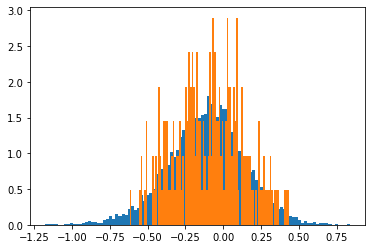

In [27]:
_ = plt.hist(correct, bins=100, density=True)
_ = plt.hist(mislabel, bins=100, density=True)

In [10]:
aum = torch.zeros([epoch, len(dataset), n_classes])
aum[e] = logits_store - logits_topk[:, 0][:, None]
aum[e, range(aum.shape[1]), logits_topk_ind[:,0]] = logits_store[range(aum.shape[1]), logits_topk_ind[0,0]] - logits_topk[:,1]

RuntimeError: expected device cpu but got device cuda:0

In [7]:
len(dataset)

9815

In [5]:
aum[e, ind, dataset[ind][2]]

IndexError: list index out of range

In [6]:
aum = torch.zeros([epoch, len(dataset), n_classes])
aum[e]=logits_store - logits_topk[0][None]
aum[e, range(aum.shape[1]), logits_topk_ind[:,0]] = logits_store[range(aum.shape[1]), logits_topk_ind[0,0]] - logits_topk[:,1]

RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

In [8]:
(logits_store - logits_topk[0][None]).shape
# - logits_topk[1, 0]

RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

In [6]:
with open("./multinli_1.0/multinli_1.0_train.jsonl") as f:
    for idx, line in enumerate(f):
        if idx>10:
            continue
        print(f)

<_io.TextIOWrapper name='./multinli_1.0/multinli_1.0_train.jsonl' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./multinli_1.0/multinli_1.0_train.jsonl' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./multinli_1.0/multinli_1.0_train.jsonl' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./multinli_1.0/multinli_1.0_train.jsonl' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./multinli_1.0/multinli_1.0_train.jsonl' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./multinli_1.0/multinli_1.0_train.jsonl' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./multinli_1.0/multinli_1.0_train.jsonl' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./multinli_1.0/multinli_1.0_train.jsonl' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./multinli_1.0/multinli_1.0_train.jsonl' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./multinli_1.0/multinli_1.0_train.jsonl' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='./multinli_1.0/multinli_1.0_train.jsonl' mode